Code using Turkana county shapefiles to create timeseries for each sub-county for study sites

In [ ]:
import numpy as np
import xarray as xr
import scipy
import sys 
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature
import warnings
warnings.filterwarnings('ignore')

data_in = "/Volumes/blue_wd/chirps_daily/"
data_out = "/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/4_ClimateForAL/python_output/data_out/"
plot_out = "/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/4_ClimateForAL/python_output/plot_out/"

Read in shapefiles with geopandas

In [ ]:
shape_c = gpd.read_file('/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/4_ClimateForAL/shapefiles/Turkana_Boundary.shp')
shape_sc = gpd.read_file('/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/4_ClimateForAL/shapefiles/Turkana_Subcounties.shp')
shape_w = gpd.read_file('/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/4_ClimateForAL/shapefiles/Turkana_Wards.shp')
#print(shape_w.keys())
#print(shape_w['ward'].values)
print(shape_c)

# Rainfall section

Read in CHIRPS (to do: TAMSAT) daily rainfall files

Run this block if you are running the code for the first time to create a smaller rainfall file to use

In [ ]:
Y1=1981
Y2=2024
lats=.5
latn=6
lonw=33
lone=37

#for Y in range(Y1,Y2+1):
#    pr_in = xr.open_dataset(data_in+"chirps-v2.0."+str(Y)+".days_p05.nc")['precip']
#    pr_in = pr_in.rename({'latitude':'lat'})
#    pr_in = pr_in.rename({'longitude':'lon'})
#    pr_in = pr_in.sel(lat=slice(lats,latn),lon=slice(lonw,lone))
#    if Y == Y1:
#      pr = pr_in
#    else:
#      pr = xr.concat([pr, pr_in], 'time')
#    del pr_in
#pr.to_netcdf(data_out+'pr_out.nc')

Run this block if you have created a truncated output file

In [ ]:
pr=xr.open_dataarray(data_out+'pr_out.nc')

Cut out a ward using the shapefiles and create annual and seasonal mean arrays. All of the different arrays will be put into a single shapefile cut dictionary. 

In [ ]:
pr.rio.write_crs("epsg:4326", inplace=True)
prw = {}
for WARD in shape_w['ward'].values: 
    pr_ward = pr.rio.clip(shape_w[shape_w['ward']==WARD].geometry.apply(mapping),
                          shape_w[shape_w['ward']==WARD].crs)
    #Create a dictionary for all the different arrays
    if WARD=='Kaaleng/kaikor Ward':
        WARD='Kaaleng-kaikor Ward'
    if WARD =='Lokiriama/Lorengippi Ward':
        WARD='Lokiriama-Lorengippi Ward'
    if WARD =='Kapedo/napeitom Ward':
        WARD='Kapedo-napeitom Ward'
    if WARD=='Kotaruk/Lobei Ward':
        WARD='Kotaruk-Lobei Ward'
    if WARD=='Lokori/kochodin Ward':
        WARD='Lokori-kochodin Ward'
    prw[WARD] = {}
    prw[WARD]['Full_ts'] = pr_ward
    prw[WARD]['MAM'] = pr_ward.sel(time=pr_ward.time.dt.month.isin([3,4,5]))
    prw[WARD]['JJA'] = pr_ward.sel(time=pr_ward.time.dt.month.isin([6,7,8]))
    prw[WARD]['S'] = pr_ward.sel(time=pr_ward.time.dt.month.isin([9]))
    prw[WARD]['OND'] = pr_ward.sel(time=pr_ward.time.dt.month.isin([10,11,12]))
    prw[WARD]['JF'] = pr_ward.sel(time=pr_ward.time.dt.month.isin([1,2]))

Create a time averaged spatial map of the rainfall in the ward:
- annual mean
- seasonal means

In [ ]:
for WARD in shape_w['ward']:
    print(WARD) 
    shp = shape_w[shape_w['ward']==WARD]
    if WARD=='Kaaleng/kaikor Ward':
        WARD='Kaaleng-kaikor Ward'
    if WARD =='Lokiriama/Lorengippi Ward':
        WARD='Lokiriama-Lorengippi Ward'
    if WARD =='Kapedo/napeitom Ward':
        WARD='Kapedo-napeitom Ward'
    if WARD=='Kotaruk/Lobei Ward':
        WARD='Kotaruk-Lobei Ward'
    if WARD=='Lokori/kochodin Ward':
        WARD='Lokori-kochodin Ward'
    #Annual mean
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.OCEAN)
    #Overlay with all ward outline
    shp.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
    #Plot data
    prw[WARD]['Full_ts'].mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                           add_colorbar=True,vmin=0,vmax=2,extend="both",
                                           cbar_kwargs={"label": "Precipitation (mm/day) \n Annual Long Term Mean"})
    # for extent the order is  [West,East,South,North]
    ax.set_extent([lonw, lone, lats, latn])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(WARD)
    plt.savefig(plot_out+"pr_ann_"+WARD+".png")
    plt.show()
    plt.clf()
    
    # Seasonal means
    fig, axes = plt.subplots(ncols=5, figsize=(13, 4),subplot_kw={'projection': ccrs.PlateCarree()},sharey=True)
    for i, seas in enumerate(("JF", "MAM", "JJA", "S", "OND")):
        im = prw[WARD][seas].mean('time').plot.pcolormesh(
        ax=axes[i],
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=2,
        cmap="viridis_r",
        add_colorbar=False,
        extend="both",
        )   
        axes[i].add_feature(cartopy.feature.BORDERS)
        axes[i].add_feature(cartopy.feature.RIVERS)
        shp.plot(ax=axes[i], edgecolor='red', facecolor='none',lw=1,zorder=2,linestyle='-')
        axes[i].set_extent([shp.bounds['minx']-0.5, shp.bounds['maxx']+0.5, shp.bounds['miny']-0.5, shp.bounds['maxy']+0.5])
        gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5, linestyle='dotted')
        gl.xlabel_style = {'rotation': 45}
        gl.ylabel_style = {'rotation': 45}
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False
        axes[i].set_title(seas)
        if i!=0:
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')
        if i==0:
            axes[i].set_xlabel('')
            axes[i].set_ylabel(WARD)
            axes[i].yaxis.get_label().set_visible(True)
        if i==4:
            gl.right_labels = True
    fig.colorbar(im, ax=axes,extend='both', shrink=0.75,label="Seasonal Mean Precip (mm/day) \n "+WARD)   
    plt.tight_layout
    plt.savefig(plot_out+"pr_seas_"+WARD+".png")
    plt.show()
    plt.clf()
    

Analyse seasonal rainfall characteristics by ward:
- currently looking at the percent of the season above a high rainfall threshold and what amount of seasonal rainfall is delivered by these

In [ ]:

#Counting the number of days where rain is over a threshold amount
thresh = 1.5
for WARD in shape_w['ward']:
    print(WARD) 
    shp = shape_w[shape_w['ward']==WARD]
    if WARD=='Kaaleng/kaikor Ward':
        WARD='Kaaleng-kaikor Ward'
    if WARD =='Lokiriama/Lorengippi Ward':
        WARD='Lokiriama-Lorengippi Ward'
    if WARD =='Kapedo/napeitom Ward':
        WARD='Kapedo-napeitom Ward'
    if WARD=='Kotaruk/Lobei Ward':
        WARD='Kotaruk-Lobei Ward'
    if WARD=='Lokori/kochodin Ward':
        WARD='Lokori-kochodin Ward'
    for i, seas in enumerate(("JF", "MAM", "JJA", "S", "OND")):
        abt = prw[WARD][seas].where((prw[WARD][seas]>thresh), drop=True)
        abt_count = abt.groupby('time.year').count(dim='time')
        abt_count = abt_count.mean(dim=('year','lat','lon')).values
        
        #Counting the number of days where rain is below threshold amount
        thresh = 0.5
        bt = prw[WARD][seas].where((prw[WARD][seas]<thresh), drop=True)
        bt_count = bt.groupby('time.year').count(dim='time')
        bt_count = bt_count.mean(dim=('year','lat','lon')).values
        
        #Accumulation of seasonal rainfall
        accum = prw[WARD][seas].groupby('time.year').sum(dim='time')
        accum = accum.mean(dim=('year','lat','lon')).values
        
        #Accumulation of rainfall on heavy rain days
        accumh = abt.groupby('time.year').sum(dim='time')
        accumh = accumh.mean(dim=('year','lat','lon')).values
        
        print(WARD,'-',seas)
        print('Count above threshold (yearly ward average): ',abt_count)
        print('Count below threshold (yearly ward average): ',bt_count)
        print('Accumulated total seasonal rainfall (yearly ward average): ',accum)
        print('Accumulated above threshold seasonal rainfall (yearly ward average): ',accumh)
        print('Percent of rainfall coming from above threshold days: %',100.0*(accumh/accum))

Calculate the number of seasons and their onset and cessation dates from a regional mean of the Turkana county rainfall
- this calculation is based on the cumulative method

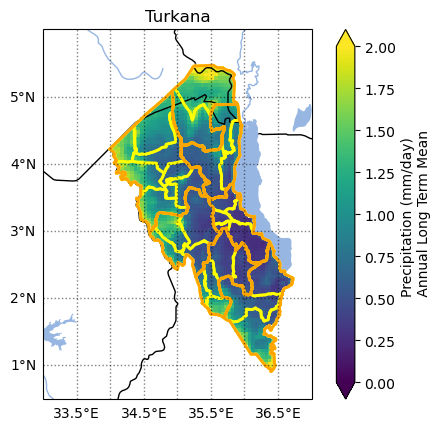

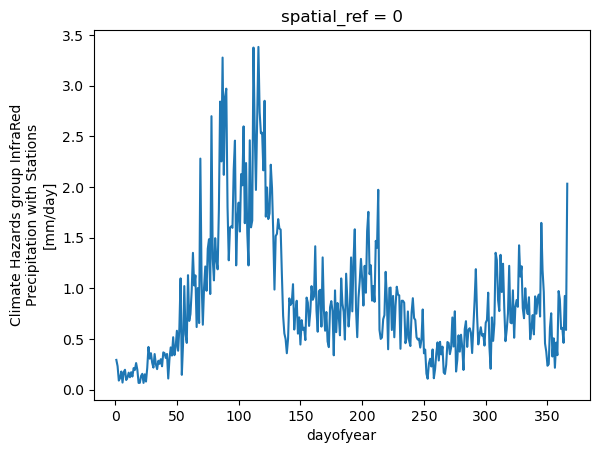

Turkana County


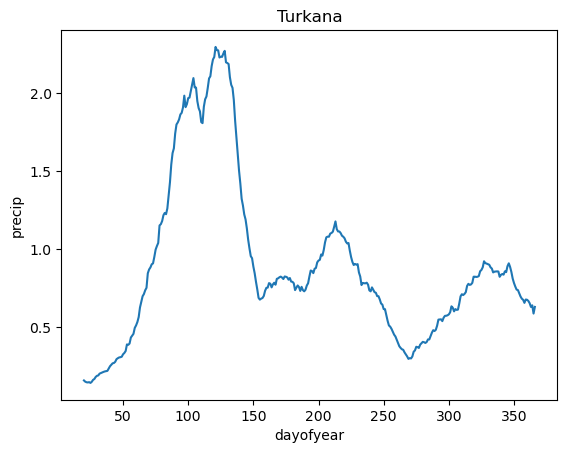

p1 0.06
p2 0.05
p3 0.06


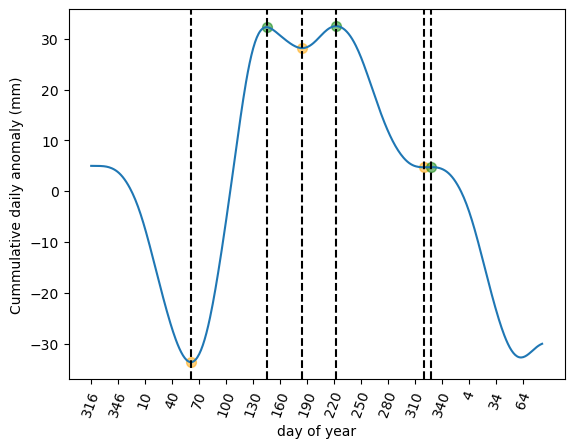

Season 1 -  base:  61 145 lt avg:  76.0 133.9268292682927
Season 2 -  base:  184 222 lt avg:  190.10344827586206 214.17241379310346
Season 3 -  base:  320 328 lt avg:  310.64285714285717 326.7142857142857


<Figure size 640x480 with 0 Axes>

In [ ]:
#Characteristic onset and cessation dates for accumulation method
import ts_onset_cess as onc
pr_turkana = pr.rio.clip(shape_c.geometry.apply(mapping),shape_c.crs)
#pr_turkana = pr_turkana.sel(lat=slice(3,6))

#Annual mean
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES)
#Overlay with all ward outline
shape_c.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
shape_w.plot(ax=ax, edgecolor='yellow',facecolor='none',lw=2,zorder=2,linestyle='-')
shape_sc.plot(ax=ax, edgecolor='orange',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
pr_turkana.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,vmin=0,vmax=2,extend="both",
                                       cbar_kwargs={"label": "Precipitation (mm/day) \n Annual Long Term Mean"})
# for extent the order is  [West,East,South,North]
ax.set_extent([lonw, lone, lats, latn])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Turkana')
#plt.savefig(plot_out+"pr_ann_"+WARD+".png")
plt.show()
plt.clf()

#Daily climatology of long term mean Turkana rainfall
t_day = pr_turkana.groupby('time.dayofyear').mean(dim=('time','lat','lon'))
t_day.plot()
plt.show()
plt.clf()

#Turkana county seasons and onset and cessation dates
print('Turkana County')
ptts = pr_turkana.mean(dim=('lat','lon'))
ptday = ptts.groupby('time.dayofyear').mean('time')
ptday.rolling(dayofyear=20).mean().plot()
plt.title('Turkana')
plt.show()
plt.clf()
power_ratio,on1,ce1,on2,ce2,on3,ce3,on1_years,ce1_years,on2_years,ce2_years,on3_years,ce3_years = onc.xarray_on_cess_point(pr_turkana.mean(dim=('lat','lon')))
print('Season 1 - ', 'base: ',on1, ce1, 'lt avg: ', on1_years.mean().values, ce1_years.mean().values)
print('Season 2 - ', 'base: ',on2, ce2, 'lt avg: ', on2_years.mean().values, ce2_years.mean().values)
print('Season 3 - ', 'base: ',on3, ce3, 'lt avg: ', on3_years.mean().values, ce3_years.mean().values)

- Calculate daily climatology of rainfall averaged for each ward
- Calculate the number of seasons and onset and cessation dates for average rainfall in each ward
- Using the cumulative method

In [ ]:

for WARD in shape_w['ward']:
    shp = shape_w[shape_w['ward']==WARD]
    if WARD=='Kaaleng/kaikor Ward':
        WARD='Kaaleng-kaikor Ward'
    if WARD =='Lokiriama/Lorengippi Ward':
        WARD='Lokiriama-Lorengippi Ward'
    if WARD =='Kapedo/napeitom Ward':
        WARD='Kapedo-napeitom Ward'
    if WARD=='Kotaruk/Lobei Ward':
        WARD='Kotaruk-Lobei Ward'
    if WARD=='Lokori/kochodin Ward':
        WARD='Lokori-kochodin Ward'
    print(WARD)
    ptts = prw[WARD]['Full_ts'].mean(dim=('lat','lon'))
    ptday = ptts.groupby('time.dayofyear').mean('time')
    ptday.rolling(dayofyear=20).mean().plot()
    plt.title(WARD)
    plt.show()
    plt.clf()
    power_ratio,on1,ce1,on2,ce2,on3,ce3,on1_years,ce1_years,on2_years,ce2_years,on3_years,ce3_years = onc.xarray_on_cess_point(prw[WARD]['Full_ts'].mean(dim=('lat','lon')))
    print('Season 1 - ', 'base: ',on1, ce1, 'lt avg: ', on1_years.mean().values, ce1_years.mean().values)
    print('Season 2 - ', 'base: ',on2, ce2, 'lt avg: ', on2_years.mean().values, ce2_years.mean().values)
    print('Season 3 - ', 'base: ',on3, ce3, 'lt avg: ', on3_years.mean().values, ce3_years.mean().values)


In [ ]:
#Characteristic onset and cessation dates for KMD/ICPAC method

## NDVI Section:
- Read in MODIS NDVI and apply scaling factor
- Create an array that is cut out for Turkana
- Plot an annual mean picutre of the NDVI for the whole county with enough regional context to inform migration decision-making

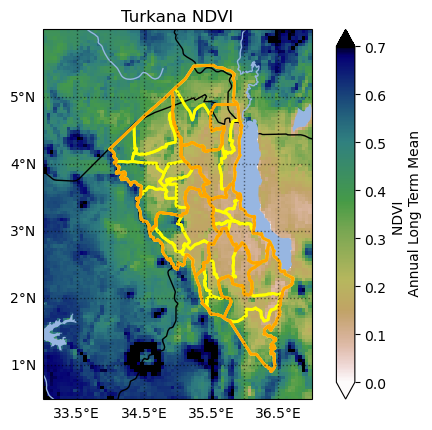

<Figure size 640x480 with 0 Axes>

In [22]:
modis_data_in = xr.open_dataarray("/Volumes/blue_wd/MODIS_61_VEG/modis_ndvi.nc")/10000.0
modis_data_in = modis_data_in.rio.set_spatial_dims(x_dim="lon",y_dim="lat")
ndvi = modis_data_in.rio.write_crs("epsg:4326", inplace=True)
ndvi_turkana = ndvi.rio.clip(shape_c.geometry.apply(mapping),shape_c.crs)

#Annual mean
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES)
#Overlay with all ward outline
shape_c.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
shape_w.plot(ax=ax, edgecolor='yellow',facecolor='none',lw=2,zorder=2,linestyle='-')
shape_sc.plot(ax=ax, edgecolor='orange',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
ndvi.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       vmin=0,vmax=0.7,
                                       cmap=plt.cm.gist_earth_r,
                                       extend="both",
                                       cbar_kwargs={"label": "NDVI \n Annual Long Term Mean"})
# for extent the order is  [West,East,South,North]
ax.set_extent([lonw, lone, lats, latn])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Turkana NDVI')
#plt.savefig(plot_out+"pr_ann_"+WARD+".png")
plt.show()
plt.clf()


Create a seasonal dictionary for NDVI
- not splitting into wards etc. because this information is being used for context

In [23]:
ndvid = {}
ndvid['Full_ts'] = ndvi
ndvid['MAM'] = ndvi.sel(time=ndvi.time.dt.month.isin([3,4,5]))
ndvid['JJA'] = ndvi.sel(time=ndvi.time.dt.month.isin([6,7,8]))
ndvid['S'] = ndvi.sel(time=ndvi.time.dt.month.isin([9]))
ndvid['OND'] = ndvi.sel(time=ndvi.time.dt.month.isin([10,11,12]))
ndvid['JF'] = ndvi.sel(time=ndvi.time.dt.month.isin([1,2]))

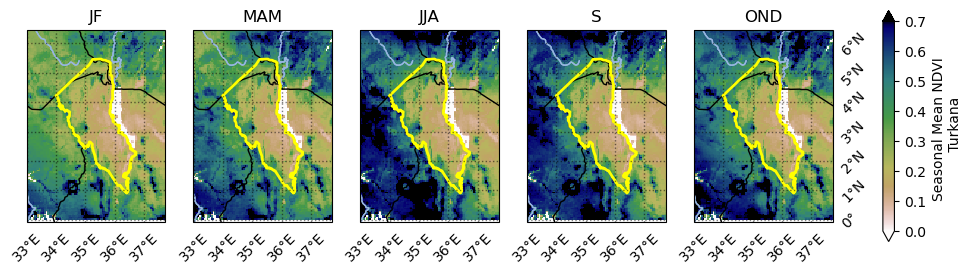

<Figure size 640x480 with 0 Axes>

In [30]:
# Seasonal means
fig, axes = plt.subplots(ncols=5, figsize=(13, 4),subplot_kw={'projection': ccrs.PlateCarree()},sharey=True)
for i, seas in enumerate(("JF", "MAM", "JJA", "S", "OND")):
    im = ndvid[seas].mean('time').plot.pcolormesh(
    ax=axes[i],
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=0.7,
    cmap=plt.cm.gist_earth_r,
    add_colorbar=False,
    extend="both",
    )   
    axes[i].add_feature(cartopy.feature.BORDERS)
    axes[i].add_feature(cartopy.feature.RIVERS)
    axes[i].add_feature(cartopy.feature.RIVERS)
    shape_c.plot(ax=axes[i], edgecolor='yellow', facecolor='none',lw=2,zorder=2,linestyle='-')
    axes[i].set_extent([shape_c.bounds['minx']-1, shape_c.bounds['maxx']+1, shape_c.bounds['miny']-1, shape_c.bounds['maxy']+1])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.xlabel_style = {'rotation': 45}
    gl.ylabel_style = {'rotation': 45}
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    axes[i].set_title(seas)
    if i!=0:
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    if i==0:
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Turkana')
        axes[i].yaxis.get_label().set_visible(True)
    if i==4:
        gl.right_labels = True
fig.colorbar(im, ax=axes,extend='both', shrink=0.75,label="Seasonal Mean NDVI \n "+"Turkana")   
plt.tight_layout
plt.savefig(plot_out+"ndvi_seas_Turkana.png")
plt.show()
plt.clf()

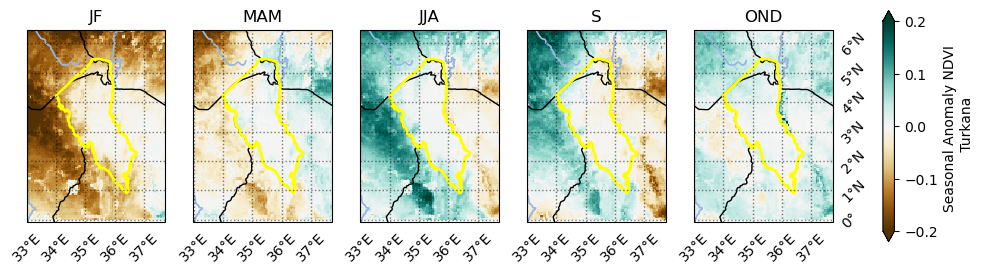

<Figure size 640x480 with 0 Axes>

In [34]:
# Seasonal anomalies
fig, axes = plt.subplots(ncols=5, figsize=(13, 4),subplot_kw={'projection': ccrs.PlateCarree()},sharey=True)
for i, seas in enumerate(("JF", "MAM", "JJA", "S", "OND")):
    anom = ndvid[seas].mean('time') - ndvid['Full_ts'].mean('time') 
    im = anom.plot.pcolormesh(
    ax=axes[i],
    transform=ccrs.PlateCarree(),
    vmin=-0.2,
    vmax=0.2,
    cmap=plt.cm.BrBG,
    add_colorbar=False,
    extend="both",
    )   
    axes[i].add_feature(cartopy.feature.BORDERS)
    axes[i].add_feature(cartopy.feature.RIVERS)
    axes[i].add_feature(cartopy.feature.RIVERS)
    shape_c.plot(ax=axes[i], edgecolor='yellow', facecolor='none',lw=2,zorder=2,linestyle='-')
    axes[i].set_extent([shape_c.bounds['minx']-1, shape_c.bounds['maxx']+1, shape_c.bounds['miny']-1, shape_c.bounds['maxy']+1])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.xlabel_style = {'rotation': 45}
    gl.ylabel_style = {'rotation': 45}
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    axes[i].set_title(seas)
    if i!=0:
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    if i==0:
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Turkana')
        axes[i].yaxis.get_label().set_visible(True)
    if i==4:
        gl.right_labels = True
fig.colorbar(im, ax=axes,extend='both', shrink=0.75,label="Seasonal Anomaly NDVI \n "+"Turkana")   
plt.tight_layout
plt.savefig(plot_out+"ndvi_seasanom_Turkana.png")
plt.show()
plt.clf()